In [1]:
# Standard library imports
import os
import datetime
import pickle
import time
from glob import glob

# Third party imports
import numpy as np
import pandas as pd
import implicit
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix, vstack
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Local imports
from Utils.utils import visualize_bought, visualize_candidates

from Models.hybrid import HybridRecommender
from Models.collaborative_filtering import ALSRecommender, SVDRecommender
from Models.content_based_filtering import ContentBasedFiltering, NumericalCBF
# Settings
os.environ['OPENBLAS_NUM_THREADS'] = '1' # Prevents OpenBLAS from using multiple threads
pd.set_option('display.max_columns', 500)

/Users/mac/miniconda3/envs/recommender/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
customers = pd.read_pickle("Data/customers.pkl")
articles = pd.read_pickle("Data/articles.pkl")
transactions = pd.read_pickle("Data/transactions.pkl")

In [3]:
images = glob("Data/images/*/*", recursive=True)
image_ids = pd.DataFrame([{'image_id': image.split('/')[-1].split('.')[0], 'path': image} for image in images])

In [4]:
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
        
# Get the last date in the dataset
last_date = transactions["t_dat"].max()

# Calculate split dates using weeks
total_period = 8  # Total weeks to consider
test_period = 1   # Weeks for testing
train_period = 7  # Weeks for training

split_start = last_date - pd.Timedelta(weeks=total_period)  # Start of training period
split_date = last_date - pd.Timedelta(weeks=test_period)    # Start of test period

# Filter to last 8 weeks and split into train/val
recent_transactions = transactions[transactions["t_dat"] >= split_start].copy()
train = recent_transactions[recent_transactions["t_dat"] < split_date].copy()
val = recent_transactions[recent_transactions["t_dat"] >= split_date].copy()

In [5]:
train_purchases = train.groupby('customer_id')['article_id'].agg(list).reset_index()
val_purchases = val.groupby('customer_id')['article_id'].agg(list).reset_index()

# Get users present in both sets
common_users = set(train_purchases['customer_id']) & set(val_purchases['customer_id'])

# Filter data for common users
train_filtered = train_purchases[train_purchases['customer_id'].isin(common_users)].reset_index(drop=True)
val_filtered = val_purchases[val_purchases['customer_id'].isin(common_users)].reset_index(drop=True)

In [6]:
articles.head(3)

,article_id,product_type_no,product_type_name,product_group_name,garment_group_no,garment_group_name,colour_group_code,colour_group_name,section_no,section_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,detail_desc
0,0108775015,253,Vest top,Garment Upper body,1002,Jersey Basic,9,Black,16,Womens Everyday Basics,4,Dark,5,Black,Jersey top with narrow shoulder straps.
1,0108775044,253,Vest top,Garment Upper body,1002,Jersey Basic,10,White,16,Womens Everyday Basics,3,Light,9,White,Jersey top with narrow shoulder straps.
2,0108775051,253,Vest top,Garment Upper body,1002,Jersey Basic,11,Off White,16,Womens Everyday Basics,1,Dusty Light,9,White,Jersey top with narrow shoulder straps.


In [7]:
user_id = '2d92b52b0e8b9f57fd433c277e5b16fb8cbdfc608c85897f86b51e91efe637be'
print("User ID: ", user_id)

User ID:  2d92b52b0e8b9f57fd433c277e5b16fb8cbdfc608c85897f86b51e91efe637be


In [8]:
methods = [ALSRecommender, SVDRecommender, ContentBasedFiltering, NumericalCBF, HybridRecommender]
candidates = {}

In [9]:
# Load models from Weights folder
model_paths = glob("Weights/*.pkl")
models = {}

for path in model_paths:
    model_name = os.path.basename(path).split('.')[0].split('_')[0]
    with open(path, 'rb') as file:
        models[model_name] = pickle.load(file)

# Display loaded models
models

{'HybridRecommender': <Models.hybrid.HybridRecommender at 0x152a3d110>,
 'NumericalCBF': <Models.content_based_filtering.NumericalCBF at 0x1470eb810>,
 'CBF': <Models.content_based_filtering.ContentBasedFiltering at 0x3437a8b90>,
 'ALSRecommender': <Models.collaborative_filtering.ALSRecommender at 0x396ffe010>,
 'SVDRecommender': <Models.collaborative_filtering.SVDRecommender at 0x342f091d0>}

In [10]:
method_to_model_key = {
    'ALSRecommender': 'ALSRecommender',
    'SVDRecommender': 'SVDRecommender',
    'ContentBasedFiltering': 'CBF',
    'NumericalCBF': 'NumericalCBF',
    'HybridRecommender': 'HybridRecommender'
}

for method in methods:
    model_key = method_to_model_key[method.__name__]
    model = models[model_key]
    candidates[method.__name__] = model.recommend_items(user_id, 4)

In [11]:
# Convert candidates dictionary to DataFrame and merge with articles for each method
candidates_df = {}

for method, candidate_list in candidates.items():
    df = pd.DataFrame(candidate_list, columns=['article_id', 'score'])
    df = df.merge(articles, on='article_id', how='left')
    candidates_df[method] = df

candidates_df

{'ALSRecommender':    article_id     score  product_type_no product_type_name  \
 0  0706016001  1.136001              272          Trousers   
 1  0706016003  0.992728              272          Trousers   
 2  0562245046  0.976137              272          Trousers   
 3  0762846008  0.944266              259             Shirt   
 
    product_group_name  garment_group_no garment_group_name  colour_group_code  \
 0  Garment Lower body              1009           Trousers                  9   
 1  Garment Lower body              1009           Trousers                 73   
 2  Garment Lower body              1009           Trousers                  9   
 3  Garment Upper body              1010            Blouses                 51   
 
   colour_group_name  section_no                section_name  \
 0             Black          53          Divided Collection   
 1         Dark Blue          53          Divided Collection   
 2             Black          15  Womens Everyday Collection 

User's historical interactions:


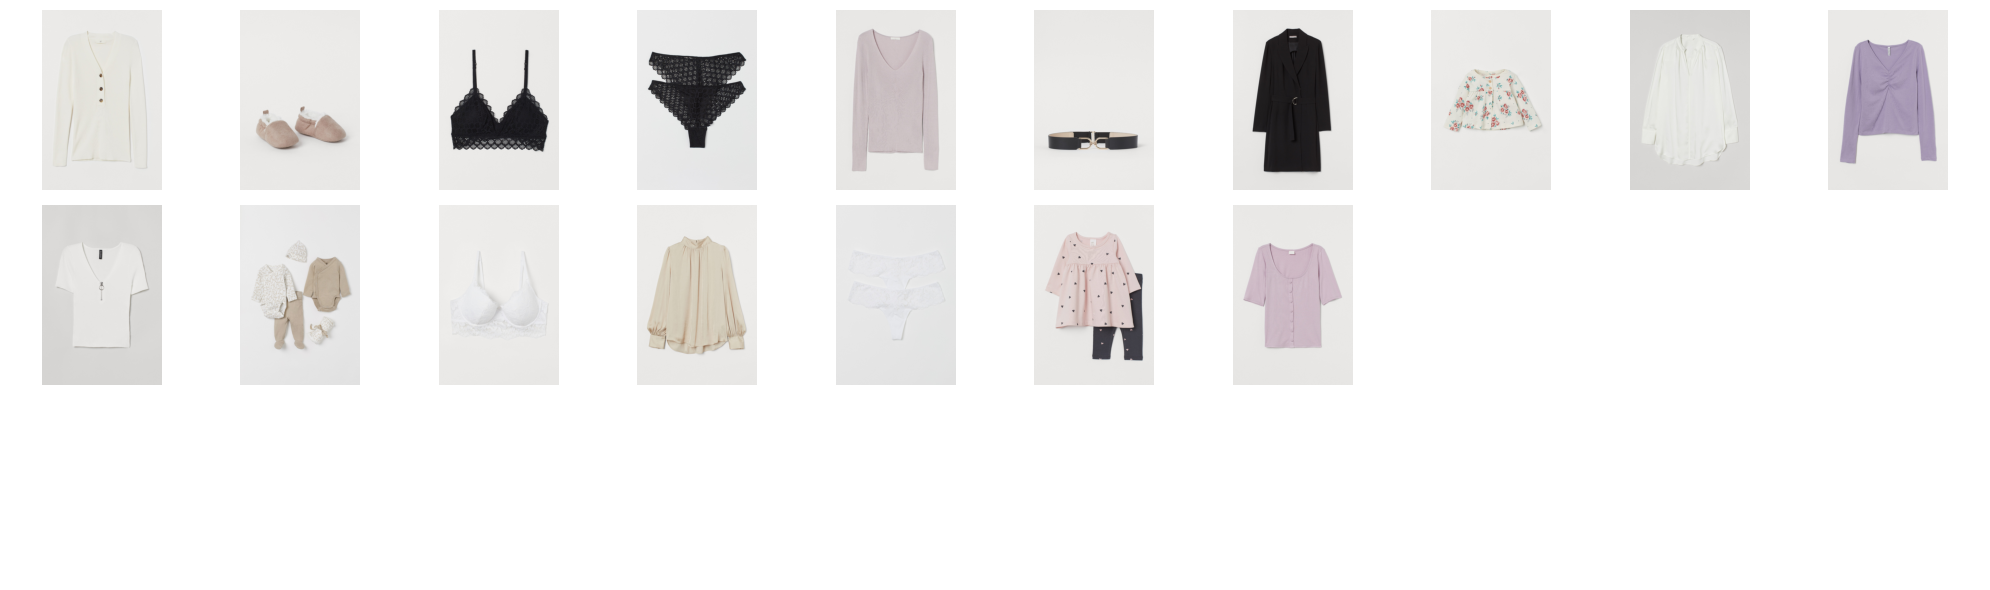

Val User's historical interactions:


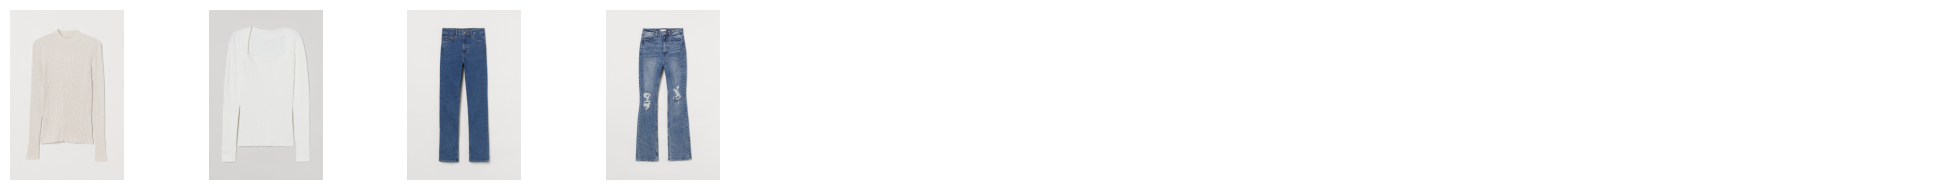

Candidates for ALSRecommender:


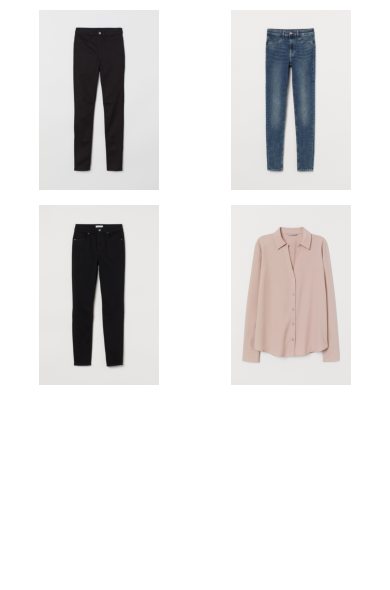

Candidates for SVDRecommender:


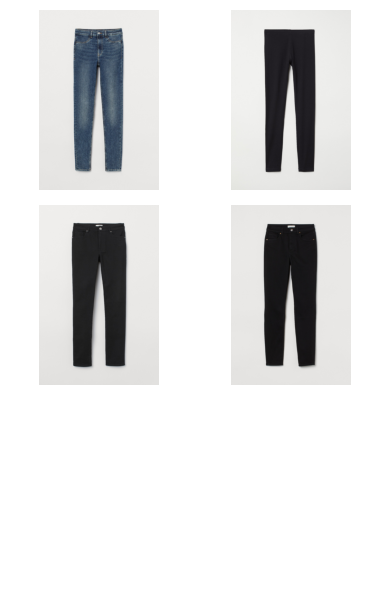

Candidates for ContentBasedFiltering:


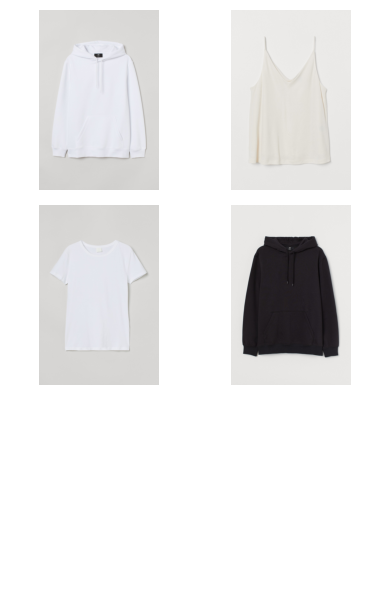

Candidates for NumericalCBF:


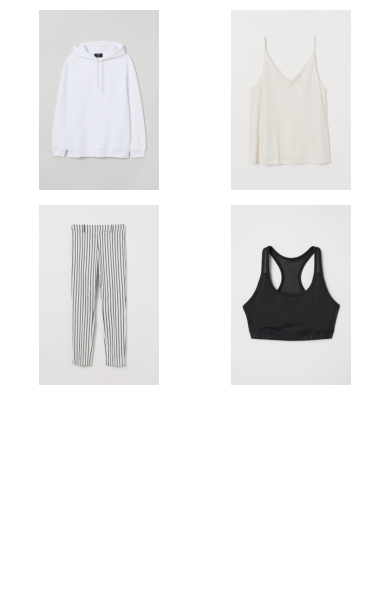

Candidates for HybridRecommender:


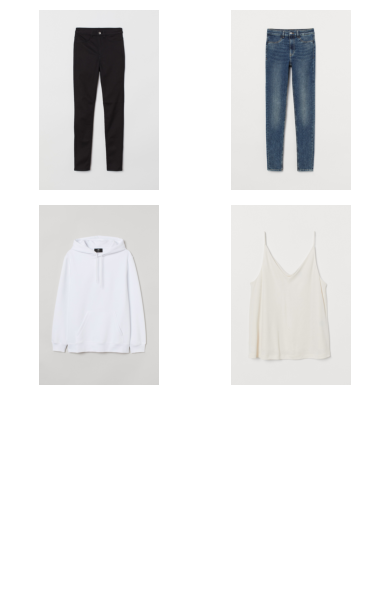

In [12]:
print("User's historical interactions:")
visualize_bought(user_id, train, image_ids)
print("Val User's historical interactions:")
visualize_bought(user_id, val, image_ids)

for method in methods:
    print(f"Candidates for {method.__name__}:")
    visualize_candidates(pd.DataFrame(candidates[method.__name__], columns=['article_id', 'score']), image_ids)